In [2]:
%matplotlib widget

+---+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
| id|              id_job|feature_type_1_0_stand|feature_type_1_1_stand|feature_type_1_2_stand|feature_type_1_3_stand|feature_type_1_4_stand|feature_type_1_5_stand|feature_type_1_6_stand|feature_type_1_7_stand|feature_type_1_8_stand|feature_type_1_9_stand|
+---+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|  0|-6888889450686994...|            0.39061737|             0.7278572|             0.5890988|            0.48813793|             0.5528158|            0.47661737|            0.53611064|             0.6366787|             0.7388

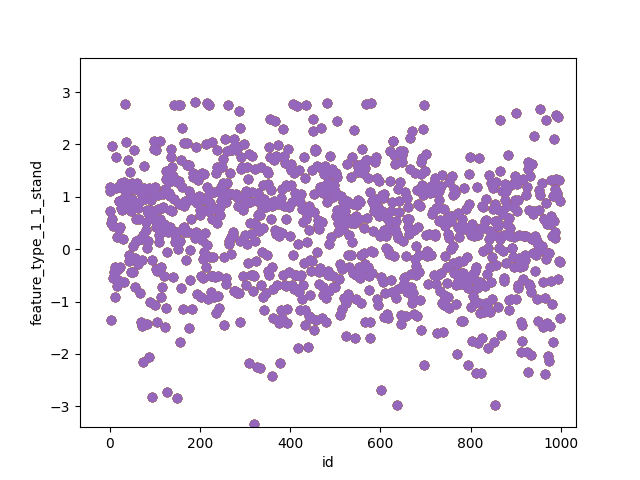

In [11]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import stddev, mean, col, udf, lit
from pyspark.sql.types import FloatType
import matplotlib.pyplot as pyplot


# Define function to compute Z-score
def z_score(x: int, mean: int, stddev: int) -> int: 
    return (x - mean) / stddev

# Convert function which compute Z-score into UDF
z_score_udf = udf(z_score, FloatType())

def transform_data(train_df: DataFrame, test_df: DataFrame, cols_names: list[str], cols_suffix : str = "") -> DataFrame:
    """
    Transform data in CSV format by computing the Z-score standardization for each value in selected columns.
    
    Parameters:
        train_df (DataFrame): input DataFrame with train data.
        test_df (DataFrame): input DataFrame with tested data.
        columns_suffix (str): Column header's suffix which will be concat with original column name to create new column name for resulting values
    """

    # Iterate over feature_type_1_{i} columns and perform z-standardization for each value in a feature column
    for col_name in cols_names:
        mean_val = lit(train_df.select(mean(col_name)).collect()[0][0])
        stddev_val = lit(train_df.select(stddev(col_name)).collect()[0][0])

        new_col_name = f"{col_name}{cols_suffix}"

        test_df = test_df.withColumn(col_name, z_score_udf(col(col_name), mean_val, stddev_val))\
                         .withColumnRenamed(col_name, new_col_name)

    return test_df


def plot_dataframe(dataframe: DataFrame, y_col: str, x_col: str, title: str = "") -> pyplot:
    # Select dataframe columns to plot
    pandas_df = dataframe.select(col(y_col), col(x_col)).toPandas()

    # Build the scatter plot
    pyplot.scatter(pandas_df[y_col], pandas_df[x_col])
    pyplot.xlabel(y_col)
    pyplot.ylabel(x_col)
    pyplot.title(title)
    return pyplot


if __name__ == "__main__":
    output_data_path = "../data/output/test_transformed.csv"

    spark = SparkSession.builder.appName("score-standardization-spark").getOrCreate()

    # Load *.csv
    train_df : DataFrame = spark.read.csv("../data/input/train.csv", header=True, inferSchema=True)
    test_df = spark.read.csv("../data/input/test.csv", header=True, inferSchema=True)

    # Enumerate column headers which starts with `feature_type_1`
    feature_cols = [ header for header in test_df.columns if header.startswith("feature_type_1_") ]

    transformed = transform_data(test_df, train_df, feature_cols, cols_suffix="_stand")

    # Write transformed data to output CSV file with pandas to avoid fragmentation
    transformed.toPandas().to_csv(output_data_path)
    transformed.show()

    plot = plot_dataframe(transformed, y_col = "id", x_col = "feature_type_1_1_stand")
    plot.show()

    spark.stop()
